In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import \
     (LinearDiscriminantAnalysis as LDA,
      QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers

In [2]:
import cv2
import gc
import os

from PIL import Image
from glob import glob

import warnings
warnings.filterwarnings('ignore')

# Lung Cancer Detection

# Background
Lung cancer is one of the leading causes of death among Americans above the age of 35. Currently, doctors are unable to diagnose patients who develop lung cancer with accuracy, and even when patients are diagnosed with lung cancer, there are many times when the carcinoma is detected all too late. 

State-of-the-art computer vision tools have the ability to classify an assortment of objects in the real world and identify them. With the Lung and Colon Cancer Histopathological Image dataset on Kaggle, the aim of this project is to train several models (2 classical supervised learning algorithms + 2 deep CNNs) in order to predict whether a CT scan of the lungs of patients show any indicators of the development of Lung Adenocarcinomas or Lung Squamous Cell Carcinomas. 

# Dataset
## Lung and Colon Cancer Histopathological Images
- 25,000 images of 5 classes including lung and colon cancer and healthy samples
- Images of size 768 x 768 pixels in jpeg format
- HIPAA compliant
### Lung Image Dataset
- 750 original images of lung tissue
  - 250 benign lung tissue
  - 250 lung adenocarcinomas
  - 250 lung squamous cell carcinomas
  - Augmented to 25,0000 images

Original Article

Borkowski AA, Bui MM, Thomas LB, Wilson CP, DeLand LA, Mastorides SM. Lung and Colon Cancer Histopathological Image Dataset (LC25000). arXiv:1912.12142v1 [eess.IV], 2019

## Data Preparation

In [3]:
lung_images = 'data/lung_image_sets'
classes = os.listdir(lung_images)
classes

['lung_aca', 'lung_n', 'lung_scc']

Here, lung_n equates to CT scans of patients with normal lungs, lung_aca equates to CT scans of patients with lung adenocarcinomas, and lung_scc equates to CT scans of patients with lung squamous cell carcinomas.

In [4]:
class_map = {
    'lung_n': 'Normal Lungs',
    'lung_aca': 'Lung Adenocarcinomas',
    'lung_scc': 'Lung Squamous Cell Carcinomas'
}

### Class Distribution

In [5]:
class_counts = {}
for c, condition in class_map.items():
    count = len(os.listdir(f'{lung_images}/{c}'))
    class_counts[condition] = count
class_counts

{'Normal Lungs': 5000,
 'Lung Adenocarcinomas': 5000,
 'Lung Squamous Cell Carcinomas': 5000}

Text(0, 0.5, '# Images')

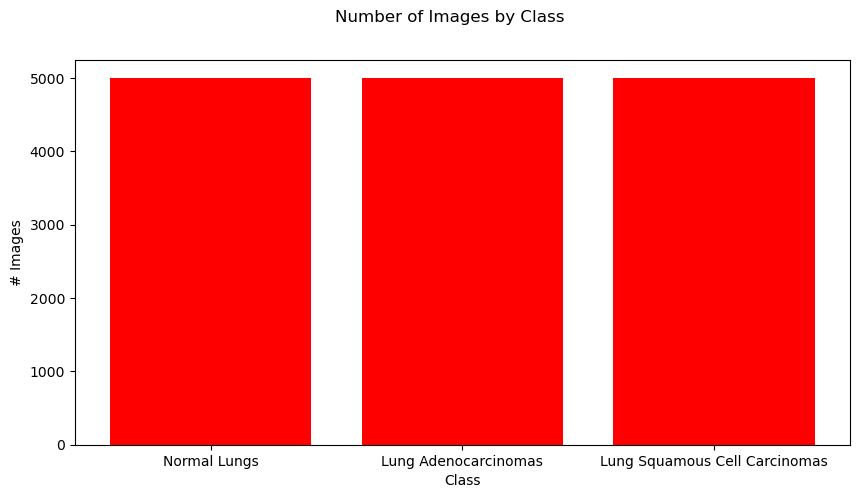

In [6]:
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle("Number of Images by Class")
ax.bar(class_counts.keys(), class_counts.values(), color='r')
ax.set_xlabel("Class")
ax.set_ylabel("# Images")

From the barplot above, we see that our dataset is well-balanced in terms of the number of samples we have in each class which can be used to train predictive models. Each class (normal lungs, lung adenocarcinomas, lung squamous cell carcinomas) has 5,000 image samples.

### Image Samples

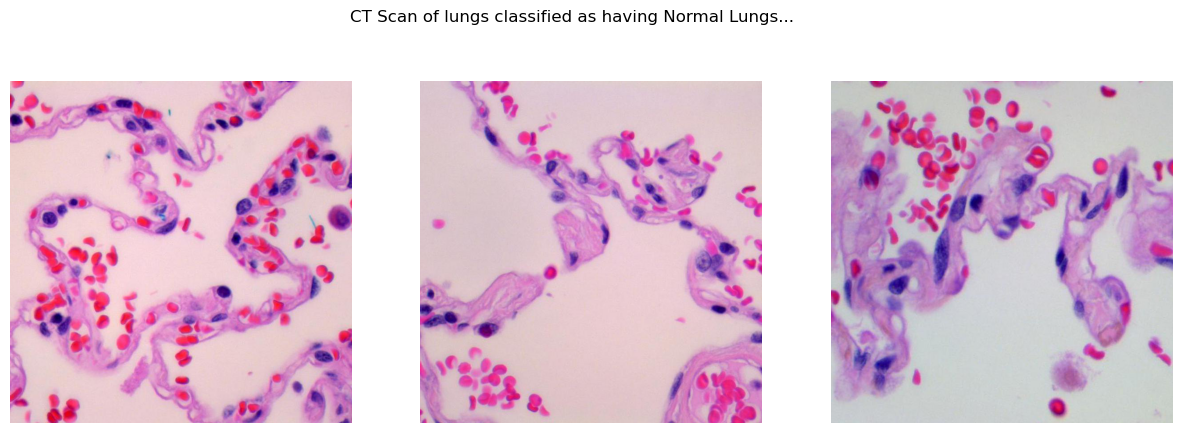

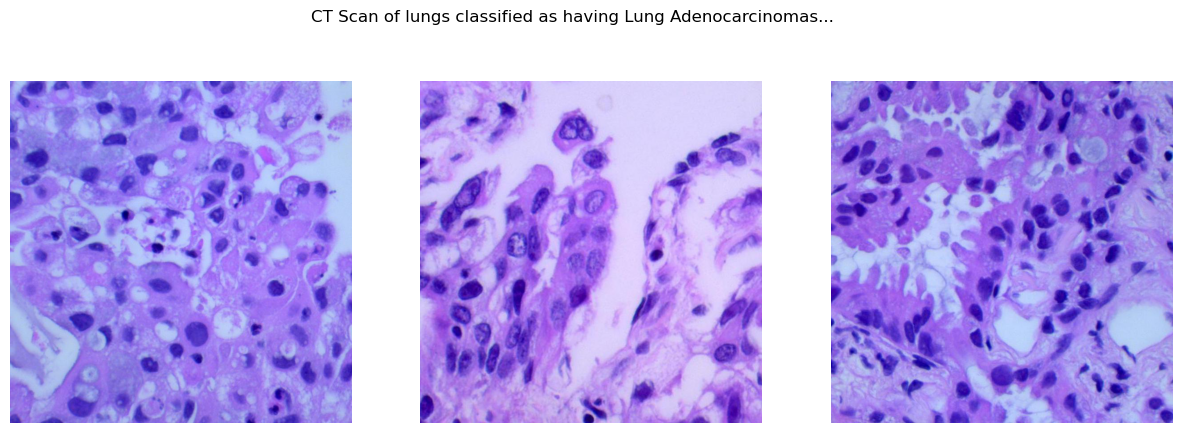

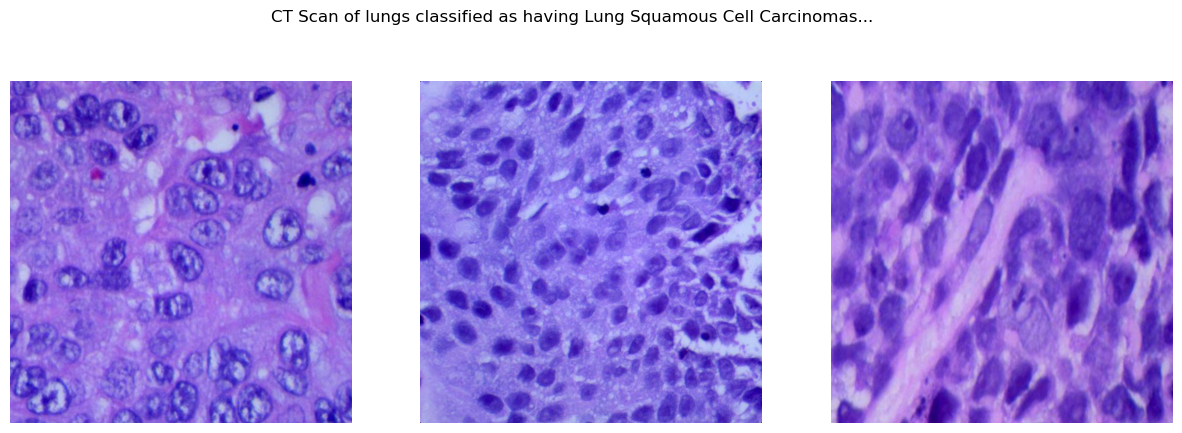

In [7]:
for c, condition in class_map.items():
    images = os.listdir(f'{lung_images}/{c}')

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'CT Scan of lungs classified as having {condition}...')

    for i in range(3):
        j = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{lung_images}/{c}/{images[j]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

Above, we have plotted 3 image samples from each class just to get a view of the data for which our models will be working with. The most obvious difference between images samples in between the classes is that cell carcinomas (cells with lung adenocarcinomas and cells with lung squamous cell carcinomas) are stained purple while normal lung cells without carcinomas are stained pink. From rudimentary research, cell carcinomas can be properly detected and stained with a variety of methods including immunohistochemistry, H&E staining, dyes binding to cancer cell nuclei, etc.. 

This may prove to be a crucial feature in predictive analysis; however, cell staining seen in CT scans may not be enough to train a model which can accurately predict whether a CT scan of lung cells contains lung cell carcinomas or not. Let's continue with our EDA and examine what results we get from future predictive analysis.

### Image Dimensions

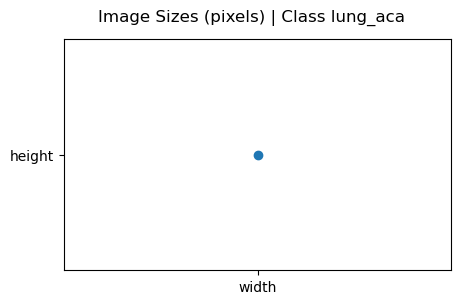

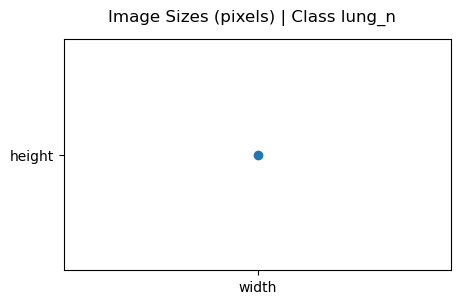

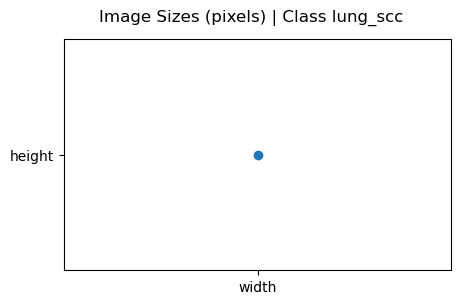

In [8]:
for i, c in enumerate(classes):
    images = glob(f'{lung_images}/{c}/*jpeg')

    fig, ax = plt.subplots(figsize=(5, 3))
    fig.suptitle(f'Image Sizes (pixels) | Class {c}')

    height, width = [], []
    for image in images:
        img = cv2.imread(image)
        h, w, c = img.shape
        height.append(h)
        width.append(w)
    
    ax.scatter(x='width', y='height')

Here, we see that all images in all classes have image dimensions of 768 pixels (height) x 768 pixels (width). Consistency in image sizes is pertinent when training CNNs for image processing. Our current dataset achieves that; however, let's downsize the images to reduce computation / training time for our image processing models as training a model on 768 x 768 x 3 images can be quite computationally expensive at scale.

### Image Processing / Resizing

In [9]:
IMAGE_SIZE = 128
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [10]:
X = []
y = []

for i, c in enumerate(classes):
    images = glob(f'{lung_images}/{c}/*jpeg')

    for image in images:
        img = cv2.imread(image)
        img_resized = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))

        X.append(img_resized)
        y.append(i)

In [11]:
X = np.array(X)
y = pd.get_dummies(y).values

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= SPLIT, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12000, 128, 128, 3), (3000, 128, 128, 3), (12000, 3), (3000, 3))

Now that we've finised our exploratory data analysis (EDA) and data preparation, we can move onto predictive analysis.

## Classical Machine Learning

In [16]:
def print_classification_metrics(y_true, y_pred, model_type):
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)

    print(f"Test accuracy of {model_type} model: {accuracy:.2f}")
    print(f"Test precision of {model_type} model: {precision:.2f}")
    print(f"Test recall of {model_type} model: {recall:.2f}")
    print(f"Test f1 score of {model_type} model: {f1:.2f}")

### Data Preparation

In [39]:
X_train.shape, X_test.shape

((12000, 128, 128, 3), (3000, 128, 128, 3))

In [40]:
def reshape_array(arr):
    return arr.reshape(len(arr), -1)

In [41]:
X_train_flat = reshape_array(X_train)
X_train_flat.shape

(12000, 49152)

In [42]:
X_test_flat = reshape_array(X_test)
X_test_flat.shape

(3000, 49152)

In [45]:
y_train.shape, y_test.shape

((12000, 3), (3000, 3))

### K-Nearest Neighbors

In [47]:
knn1 = KNeighborsClassifier()
knn1.fit(X_train_flat, y_train)
knn1_pred = knn1.predict(X_test_flat)

In [49]:
knn1_pred

array([[False,  True, False],
       [False, False,  True],
       [ True, False, False],
       ...,
       [False, False,  True],
       [False, False,  True],
       [False, False,  True]])

In [48]:
confusion_matrix(y_test, knn1_pred)

ValueError: multilabel-indicator is not supported

### Support Vector Machine

#### Black and Whiten Images

## Deep Learning

### AlexNet Architecture

### VGGNet

### Resnet

### Dense Net

### Efficient Net